In [1]:
import pandas as pd

df = pd.read_csv('../data/combined_extracted_features_dataset.csv')
df.head()

,Having IP address,Having @ symbol,URL length >= 54,Multiple subdomains,Redirection //,HTTP instead of HTTPS,URL shortening service,Prefix/Suffix in domain,DNS record missing,Domain age < 6 months,Domain expires in <6 months,Iframe detected,Mouse-over script,Right-click disabled,Multiple forwarding,target
0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0
2,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0
4,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0


In [2]:
df.isna().sum()

Having IP address              0
Having @ symbol                0
URL length >= 54               0
Multiple subdomains            0
Redirection //                 0
HTTP instead of HTTPS          0
URL shortening service         0
Prefix/Suffix in domain        0
DNS record missing             0
Domain age < 6 months          0
Domain expires in <6 months    0
Iframe detected                0
Mouse-over script              0
Right-click disabled           0
Multiple forwarding            0
target                         0
dtype: int64

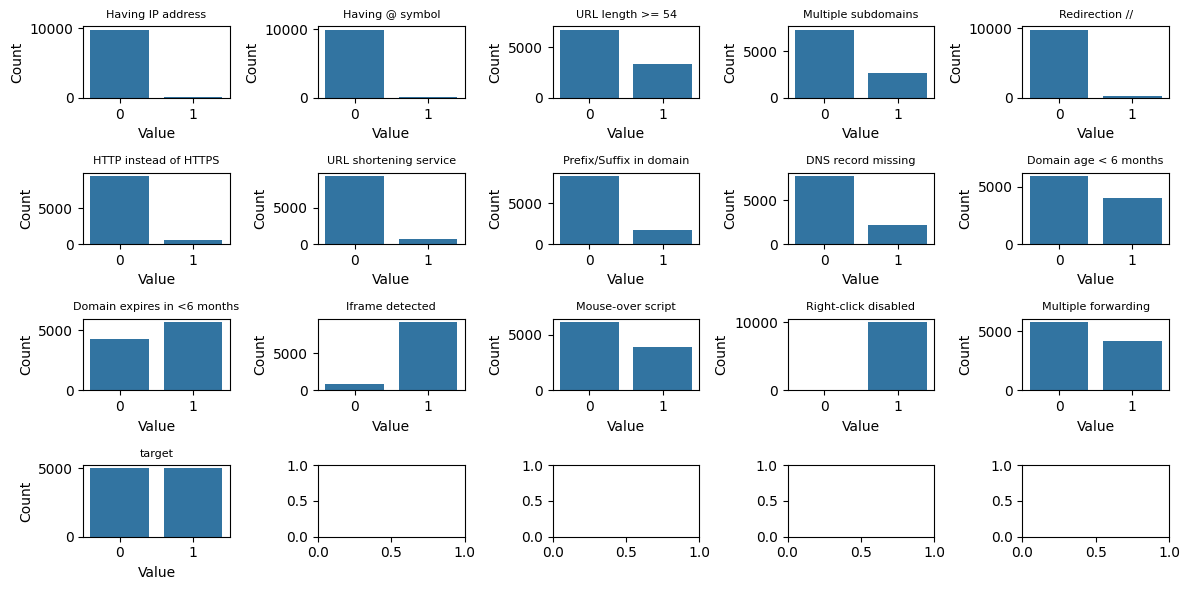

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns 

# fig, axes = plt.subplots(len(df.columns)//4, 5, figsize=(12, 6))
# axes = axes.flatten()

# for i, col in enumerate(df.columns):
#     sns.countplot(data=df, x=col, ax=axes[i])
#     axes[i].set_title(col, fontsize=8)
#     axes[i].set_xlabel("Value")
#     axes[i].set_ylabel("Count")

# plt.tight_layout()
# plt.show()

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='target').values
y = df['target'].values

In [34]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

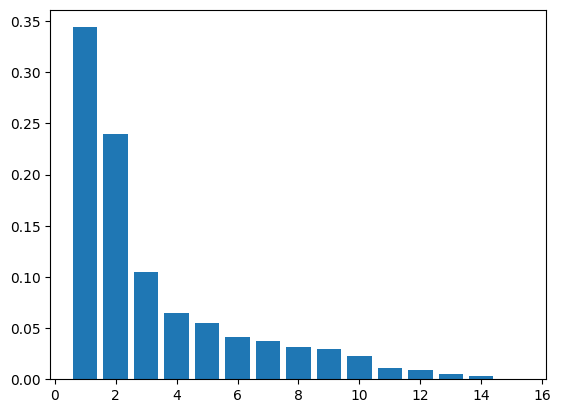

In [35]:
import matplotlib.pyplot as plt

plt.bar(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_)
plt.show()

In [25]:
sum = 0
for i, com in enumerate(pca.explained_variance_ratio_):
    sum  += com
    print(f"PCA at {i+1} explaned {sum*100:.2f}%")    

PCA at 1 explaned 34.28%
PCA at 2 explaned 58.42%
PCA at 3 explaned 68.92%
PCA at 4 explaned 75.33%
PCA at 5 explaned 80.86%
PCA at 6 explaned 85.03%
PCA at 7 explaned 88.69%
PCA at 8 explaned 91.88%
PCA at 9 explaned 94.82%
PCA at 10 explaned 97.09%
PCA at 11 explaned 98.24%
PCA at 12 explaned 99.17%
PCA at 13 explaned 99.68%
PCA at 14 explaned 99.99%
PCA at 15 explaned 100.00%


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf, X_train, y_train,
    cv=5,
    scoring='f1'
)

print("CV scores:", scores)
print("Mean CV score:", scores.mean())

CV scores: [0.89546351 0.89940828 0.89919355 0.9005305  0.90271343]
Mean CV score: 0.8994618564098109


In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [100, 200], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

best_rf = rf_grid.best_estimator_

print("Best parameters:")
print(rf_grid.best_params_)

Best parameters:
{'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [50]:
rf_pred = best_rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_pred)
print(classification_report(y_test, rf_pred, target_names=["Legitimate", "Phishing"]))

              precision    recall  f1-score   support

  Legitimate       0.87      0.95      0.91       989
    Phishing       0.95      0.85      0.90      1011

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



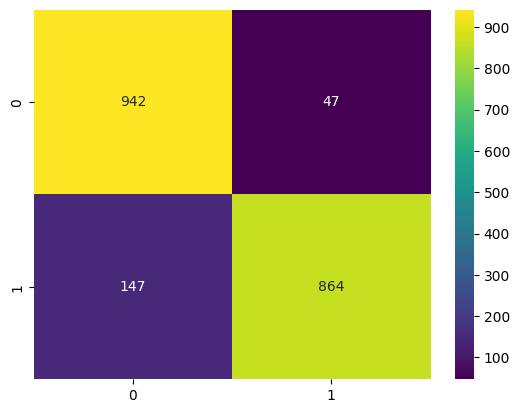

In [51]:
import seaborn as sns

sns.heatmap(rf_cm, annot=True, fmt='d',cmap='viridis')
plt.show()

### Deep Learning

In [5]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

class PhishingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = PhishingDataset(X_train, y_train)
val_dataset = PhishingDataset(X_val, y_val)
test_dataset  = PhishingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
import torch.nn as nn

class PhishingNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        # self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 16)
        # self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.drop1(x)
        x = self.relu(self.fc2(x))
        # x = self.drop2(x)
        x = self.fc3(x)
        return x

In [8]:
model = PhishingNet(input_size=X_train.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [9]:
# from tqdm import tqdm

epochs = 100
train_loss_his = []
val_loss_his = []

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    val_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_his.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            out = model(x)
            l = criterion(out, y)
            val_loss += l.item()
        
    avg_val_loss = val_loss / len(val_loader)
    val_loss_his.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {train_loss:.4f}, Val: {val_loss}")


Epoch [10/100], Loss: 59.4336, Val: 7.298823200166225
Epoch [20/100], Loss: 58.4133, Val: 7.476920232176781
Epoch [30/100], Loss: 58.1789, Val: 7.325408522039652
Epoch [40/100], Loss: 57.7916, Val: 7.7183579951524734
Epoch [50/100], Loss: 57.5741, Val: 7.258854664862156
Epoch [60/100], Loss: 57.4487, Val: 7.382860407233238
Epoch [70/100], Loss: 57.2310, Val: 7.339207015931606
Epoch [80/100], Loss: 57.2751, Val: 7.303911786526442
Epoch [90/100], Loss: 57.2225, Val: 7.2024282068014145
Epoch [100/100], Loss: 57.1587, Val: 7.1866056472063065


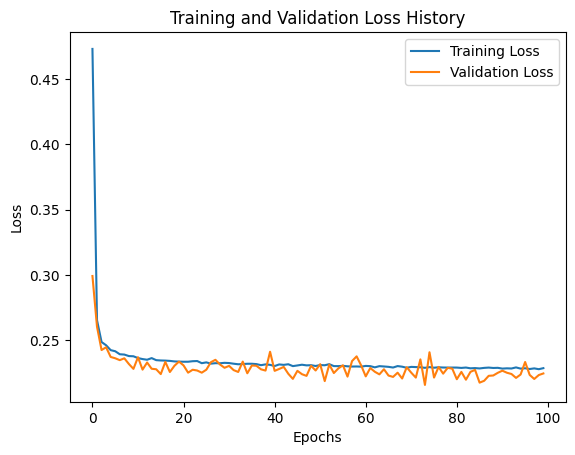

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_his, label='Training Loss')
plt.plot(val_loss_his, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')

plt.legend()
plt.show()

In [11]:
model.eval()
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        loss = criterion(outputs, yb)
        test_loss += loss.item()
        
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

accuracy = correct / total

print("Test Accuracy:", accuracy)

Test Accuracy: 0.914


In [62]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version PyTorch was built with: {torch.version.cuda}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA version PyTorch was built with: None
Is CUDA available: False


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
with torch.no_grad():
    y_pred = (model(torch.tensor(X_test, dtype=torch.float32)) > 0.5).int()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[487  13]
 [ 71 429]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       500
           1       0.97      0.86      0.91       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [13]:
torch.save(model.state_dict(), 'dl_model.pt')

---

In [16]:
import joblib


os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(model, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

Model saved to ../models/phishing_rf.pkl


In [28]:
from pathlib import Path
import sys
import numpy as np

# Add project root (parent of 'notebook') to sys.path
project_root = Path().resolve().parent  # go one level up from notebook/
sys.path.append(str(project_root))

from src.preprocess.decomposeURL import PhishingFeatureExtractor

# Create extractor
extractor = PhishingFeatureExtractor()

# Test URL
url = 'https://qrco.de/bfNcil'

features = extractor.extract(url)
print(features)

# Example for using model
X = np.array(features).reshape(1, -1)
pred = model.predict(X)[0]
proba = model.predict_proba(X)[0]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]


/Users/ougi/Documents/Project/Phishing-Detection-Using-ML/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ougi/Documents/Project/Phishing-Detection-Using-ML/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
print({
        "probability": float(proba[1]) if pred == 1 else float(proba[0]),
        "label": "legitimate" if pred == 1 else "phishing"
    })

{'probability': 1.0, 'label': 'phishing'}
